# Attribute Analysis
The following notebook can analyze a given attribute with any number of expected values (2+), and will perform metrics 1,2,3,4,11 generalized to any attribute

## Instruction
1. Fill in the dataset in section 1.1

2. Run all of the cells

3. Look at the summary pdf generated AND/OR explore each metric below.
    - Under each Metric there will be a portion of "Setup" and then "Analyses". Ignore the "Setup" unless customization is needed, and in "Analyses" results are shown to be interacted with. The number that comes after the M in the title refers to the measurement number when collecting the metrics.
    
## Table of Contents
1. [Initial Setup](#setup) <br/>
    1.1 [Dataset](#dataset) <br/>
2. (M1) Metric: [Distance from center, size, attribute label inference](#metric1)<br/>
    2.1 [Setup](#metric1_setup)<br/>
    2.2 [Analyses](#metric1_analyses)
3. (M2) Metric: [Object occurrences and cooccurrences](#metric2))<br/>
    3.1 [Setup](#metric2_setup)<br/>
    3.2 [Analyses](#metric2_analyses)

# Initial Setup
<a id="setup"></a>

In [1]:
from __future__ import print_function
from __future__ import division
import argparse
import datasets
import pickle
import itertools
import torchvision.transforms as transforms
import torch.utils.data as data
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.manifold import TSNE
import seaborn as sns
import numpy as np
from scipy import stats
import PIL.Image
from scipy.cluster.hierarchy import dendrogram, linkage
from math import sqrt
import cv2
import matplotlib.patches as patches
from scipy.spatial.distance import squareform
import pycountry
from geonamescache import GeonamesCache
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import re
import plotly.graph_objects as go
import textwrap
import matplotlib.patches as mpatches
import operator
from matplotlib.font_manager import FontProperties
import imageio
from ipywidgets import interact, interactive, fixed, interact_manual, HBox, Layout
import ipywidgets as widgets
from IPython.display import Image
from IPython.core.display import HTML
from IPython.display import display
import time
import warnings
import random
from matplotlib.transforms import Bbox
from IPython.display import clear_output
import math

In [2]:
COLORS = sns.color_palette('Set2')
SAME_EXTENT = (-0.5, 6.5, -0.5, 6.5)
np.seterr(divide='ignore', invalid='ignore')
warnings.filterwarnings("ignore")

if not os.path.exists("dataloader_files"):
    os.mkdir("dataloader_files")
if not os.path.exists("results"):
    os.mkdir("results")
if not os.path.exists("checkpoints"):
    os.mkdir("checkpoints")

In [ ]:
%matplotlib inline

In [ ]:
# https://stackoverflow.com/questions/31517194/how-to-hide-one-specific-cell-input-or-output-in-ipython-notebook
def hide_toggle(for_next=False, toggle_text='Toggle show/hide'):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)

In [ ]:
hide_toggle(for_next=True, toggle_text='Show/hide helper functions')

In [3]:
def folder(num, folder):
    if not os.path.exists("results/{0}/{1}".format(folder, num)):
        os.mkdir("results/{0}/{1}".format(folder, num))
    file = open("results/{0}/{1}/results.txt".format(folder, num), "w")
    return file

# Projecting a set of features into a lower-dimensional subspace with PCA
def project(features, dim):
    standardized = StandardScaler().fit_transform(features)
    pca = PCA(n_components=dim)
    principalComponents = pca.fit_transform(X=standardized)
    return principalComponents

# Calculating the binomial proportion confidence interval
def wilson(p, n, z = 1.96):
    denominator = 1 + z**2/n
    centre_adjusted_probability = p + z*z / (2*n)
    adjusted_standard_deviation = sqrt((p*(1 - p) + z*z / (4*n)) / n)
    
    lower_bound = (centre_adjusted_probability - z*adjusted_standard_deviation) / denominator
    upper_bound = (centre_adjusted_probability + z*adjusted_standard_deviation) / denominator
    return (lower_bound, upper_bound)

def country_to_iso3(country):
    missing = {'South+Korea': 'KOR',
            'North+Korea': 'PRK',
            'Laos': 'LAO',
            'Caribbean+Netherlands': 'BES',
            'St.+Lucia': 'LCA',
            'East+Timor': 'TLS',
            'Democratic+Republic+of+Congo': 'COD',
            'Swaziland': 'SWZ',
            'Cape+Verde': 'CPV',
            'C%C3%B4te+d%C2%B4Ivoire': 'CIV',
            'Ivory+Coast': 'CIV',
            'Channel+Islands': 'GBR'
            }
    try:
        iso3 = pycountry.countries.search_fuzzy(country.replace('+', ' '))[0].alpha_3
    except LookupError:
        try:
            iso3 = missing[country]
        except KeyError:
            iso3 = None
    return iso3

def full_extent(ax, pad=0.0):
    """Get the full extent of an axes, including axes labels, tick labels, and
    titles."""
    # For text objects, we need to draw the figure first, otherwise the extents
    # are undefined.
    ax.figure.canvas.draw()
    items = ax.get_xticklabels() + ax.get_yticklabels() 
    items += [ax, ax.title]
    bbox = Bbox.union([item.get_window_extent() for item in items])

    return bbox.expanded(1.0 + pad, 1.0 + pad)

def display_filepaths(filepaths, width=100, height=100):
    sidebyside = widgets.HBox([widgets.Image(value=open(filepath, 'rb').read(), format='png', width=width, height=height) for filepath in filepaths], layout=Layout(height='{}px'.format(height)))
    display(sidebyside)

def dec_to_show(p):
    if p < .001:
        return '{:0.3e}'.format(p)
    else:
        return round(p, 3)

## Dataset
Fill in below with dataset and file path names
<a id="dataset"></a>

In [4]:
transform_train = transforms.Compose([ 
        transforms.ToTensor()
        ])
dataset = datasets.CoCoDataset(transform_train)
folder_name = 'coco_example'

# dataset = datasets.OpenImagesDataset(transform_train)
# folder_name = 'openimages_supp'

loading annotations into memory...
Done (t=0.58s)
creating index...
index created!


In [5]:
save_loc = '1_pager_gen'
os.system("rm -r results/{0}/{1}".format(folder_name, save_loc))
file = folder(save_loc, folder_name)
first_pass = True
to_write = {}
if not os.path.exists("checkpoints/{}".format(folder_name)):
    os.mkdir("checkpoints/{}".format(folder_name))

In [ ]:
data_folder = None

distances = pickle.load(open("results/{}/3.pkl".format(folder_name), "rb"))
sample_file = distances[0][0][0][3]
if not os.path.exists(sample_file):
    assert data_folder is not None, "initialize data_folder with folder path of your data"
    dataset.init_folder_path(data_folder)
    print("overwriting from_path() function")
    dataset.from_path = dataset.from_path_prerun

In [6]:
attr_names = dataset.attribute_names
num_attrs = len(attr_names)

# (M1) Metric: Distance from center, size, attribute label inference
<a id="metric1"></a>

## Setup
<a id="metric1_setup"></a>

In [ ]:
hide_toggle(for_next=True, toggle_text='Show/hide M1 code')

In [41]:
info = pickle.load(open("results/{}/1.pkl".format(folder_name), "rb"))
sizes = info['sizes']
dists = info['distances']
tiny_sizes = info['tiny_sizes']
no_faces = info['noface_sizes']
        
scenes = [None]*num_attrs
for attr in range(num_attrs):
    try:
        scenes[attr]=np.array(list(itertools.chain.from_iterable([chunk[2] for chunk in no_faces[attr]])) + list(itertools.chain.from_iterable([chunk[1] for chunk in tiny_sizes[attr]])))
    except TypeError:
        if len(tiny_sizes)==0:
            print("There are no images with faces too small to label for group: {0}".format(attr_names[attr]))
        else:
            print("There are no images where a face is not detected for group: {0}".format(attr_names[attr]))
    tiny_sizes[attr] = [chunk[0] for chunk in tiny_sizes[attr]]
    no_faces[attr] = [chunk[0] for chunk in no_faces[attr]]
    
info = pickle.load(open('util_files/places_scene_info.pkl', 'rb'))
idx_to_scene = info['idx_to_scene']
idx_to_scenegroup = info['idx_to_scenegroup']
sceneidx_to_scenegroupidx = info['sceneidx_to_scenegroupidx']

xaxis = [idx_to_scenegroup[i] for i in range(len(idx_to_scenegroup))]
xaxis = ['\n'.join(textwrap.wrap(chunk, width=30)) for chunk in xaxis]
barWidth = .4
fontsize = 15

r1 = np.arange(len(idx_to_scenegroup))
r1 = r1 * ((barWidth * num_attrs) + .2)

scenes = [np.bincount(scenes[i]) for i in range(num_attrs)]
total_images = np.sum(scenes)
scenes_ratio = [scenes[i]/total_images for i in range(num_attrs)]

all_sizes = [tiny_sizes[i]+no_faces[i]+sizes[i] for i in range(num_attrs)]

def numbers_where_attribute_inferred():
    tiny = [len(tiny_sizes[i]) for i in range(num_attrs)]
    noface = [len(no_faces[i]) for i in range(num_attrs)]
    original = [tiny[i]+noface[i]+len(sizes[i]) for i in range(num_attrs)]
    
    total_original = np.sum(original)
    if total_original >0:
        print("Total labelled images: {0},".format(total_original))
    for i in range(num_attrs):
        if original[i]>0:
            print("{0} were {1}".format(original[i], attr_names[i]))
      
    max_original = 0
    max_attribute = -1
    for attr in range(num_attrs):
        if not math.isnan(original[attr]/total_original) and original[attr]/total_original > max_original:
            max_original = original[attr]/total_original
            max_attribute = attr
    if max_attribute > -1:
        print("{0} is assigned to {1}% labelled images in the dataset, and is the most commonly assigned label".format(attr_names[max_attribute], round(max_original, 4)*100))  
    print()
    
    tiny_total = np.sum(tiny)
    if tiny_total > 0:
        print("Discarded {0} images for being too small,".format(tiny_total))
    for i in range(num_attrs):
        if tiny[i]>0:
            print("{0} were {1}".format(tiny[i], attr_names[i]))
        
    max_original = 0
    max_attribute = -1
    for attr in range(num_attrs):
        if not math.isnan(tiny[attr]/tiny_total) and tiny[attr]/tiny_total > max_original:
            max_original = tiny[attr]/tiny_total
            max_attribute = attr
    if max_attribute > -1:
        print("{0} is assigned to {1}% labelled images where a person is too small to properly see, and is the most commonly assigned label among such images".format(attr_names[max_attribute], round(max_original, 4)*100))
    print()
    
    noface_total = np.sum(noface)
    if noface_total >0:
        print("Discarded {0} images for having no face detected,".format(noface_total))
    for i in range(num_attrs):
        if noface[i] >0:
            print("{0} were {1}".format(noface[i], attr_names[i]))
        
    max_original = 0
    max_attribute = -1
    for attr in range(num_attrs):
        if not math.isnan(noface[attr]/noface_total) and noface[attr]/noface_total > max_original:
            max_original = noface[attr]/noface_total
            max_attribute = attr
    if max_attribute > -1:
        print("{0} is assigned to {1}% labelled images where a face is not detected, and is the most commonly assigned label among such images".format(attr_names[max_attribute], round(max_original, 4)*100))
       
    labelled = [tiny[i]+noface[i] for i in range(num_attrs)]
    max_labelled = np.argmax(labelled)
    labelled_others = np.sum(labelled)
    prob = labelled[max_labelled] / labelled_others
    prob_statement = "Probability image is labeled {0} when it should not be, i.e. given there's no face detected or person is too small: {1}".format(attr_names[max_labelled], round(prob, 4))
    if (prob < .45 or prob > .55) and first_pass:
        to_write[0] = ["(M1) " + prob_statement]
    print()
    print(prob_statement)
    
def scenes_where_no_face():
    barWidths = [barWidth * i for i in range(num_attrs)]
    fig = plt.figure(figsize=(12, 6))
    r = [r1]
    for i in range(1, num_attrs+1):
        r.append([x + barWidth for x in r[len(r)-1]])
        
    scene_attr_ratios = [0 for i in range(len(scenes[0]))]
    max_scenes = [0 for i in range(len(scenes[0]))]
    for scene in range(len(scenes[0])):
        max_scene = 0
        min_scene = 1
        max_attr = -1
        for attr in range(num_attrs):
            if scenes_ratio[attr][scene] > max_scene:
                max_scene = scenes_ratio[attr][scene]
                max_attr = attr
            if scenes_ratio[attr][scene] < min_scene:
                min_scene = scenes_ratio[attr][scene]
        scene_attr_ratios[scene] = max_scene / min_scene
        max_scenes[scene] = max_attr
            
    order = np.argsort(scene_attr_ratios)
    biggest_diff_scenes = []
    if first_pass and scene_attr_ratios[order[-1]] > 1.:
        biggest_diff_scenes.append("{0} is the scene where the label of {1} is most likely to be picked over that of others".format(xaxis[order[-1]], attr_names[max_scenes[order[-1]]]))
    if first_pass and scene_attr_ratios[order[0]] < 1.:
        biggest_diff_scenes.append("{0} is the scene where the label of {1} is most likely to be picked over that of others".format(xaxis[order[0]], attr_names[max_scenes[order[0]]]))
    if len(biggest_diff_scenes) > 0:
        to_write[1] = biggest_diff_scenes
    for i in range(num_attrs-1, -1, -1):
        plt.barh(r[i], scenes_ratio[i][order], height=barWidth, color=COLORS[i], edgecolor='white', label=attr_names[i])
    ticks = r[0]+(num_attrs/2)*barWidth
    print("r", r)
    print("Ticks", ticks)
    plt.yticks(ticks, np.array(xaxis)[order], fontsize=fontsize)
    plt.xticks(fontsize=fontsize)
    plt.ylabel('Scene', fontsize=fontsize)
    plt.xlabel('Proportion of Labelled Images Discarded with this Scene', fontsize=fontsize)
    plt.legend(loc='best', prop={'size': fontsize})
    plt.title("Scenes where image was labeled when it should not have been", fontsize=fontsize)
    plt.tight_layout()
    plt.gcf().subplots_adjust(bottom=0.18)
    plt.gcf().subplots_adjust(left=0.4)
    plt.show()
    
comparisons_widget = widgets.Dropdown(options=['Sizes', 'Distances', 'All sizes', 'Sizes where no face was detected'], value='Sizes')

def compare_sizedist(metric):
    def mean_and_std(data, data_type):
        mean = [np.mean(data[i]) for i in range(num_attrs)]
        std = [np.std(data[i]) for i in range(num_attrs)]

        min_p = 100
        one = -1
        two = -1
        for i in range(num_attrs):
            for a in range(i+1, num_attrs):
                t, p = stats.ttest_ind(data[i], data[a])
                if p < min_p:
                    min_p=p
                    one = i
                    two = a
        p = min_p

        to_save = False
        if metric == 'first_pass' and p < .05 and first_pass:
            data_descrip = ''
            if data_type == 'dists':
                data_descrip = 'Distance from center'
            if data_type == 'sizes':
                data_descrip = 'Fraction of image taken up by a person'
            to_write[2] = ["(M1) {0} is different between the attributes with a p-value of {1} for the most significant pair ({2} and {3}), distribution shown below".format(data_descrip, dec_to_show(p), attr_names[one], attr_names[two])]
            to_save = True
            
        if metric == 'first_pass' or metric != 'first_pass':
            for i in range(num_attrs):
                histogram_a, bins_a = np.histogram(data[i], bins='auto')
                bin_centers_a = 0.5*(bins_a[1:] + bins_a[:-1])
                area_a = np.trapz(histogram_a, x=bin_centers_a)
                plt.plot(bin_centers_a, histogram_a/area_a, alpha=.75, label=attr_names[i], color=COLORS[i])

            plt.legend(loc='upper right')
            plt.xlabel('Distances' if data_type == 'dists' else 'Sizes')
            plt.ylabel('Frequency')
            if to_save and first_pass:
                plt.savefig("results/{0}/{1}/0.png".format(folder_name, save_loc))
                plt.close()
            elif metric == 'first_pass':
                plt.close()
            else:
                plt.show()

        if metric != 'first_pass':
            for i in range(num_attrs):
                print("{0}: {1} +- {2}\n".format(attr_names[i], round(mean[i], 4), round(std[i], 4)))
            print("The smallest P value, which is between the groups {} and {}: {}\n".format(attr_names[one],attr_names[two], '{:0.3e}'.format(p)))

    if metric == 'Sizes':
        mean_and_std(sizes, 'sizes')
    elif metric == 'All sizes':
        mean_and_std(all_sizes, 'all_sizes')
    elif metric == 'Sizes where no face was detected':
        mean_and_std(no_faces, 'no_faces')  
    elif metric == 'Distances':
        mean_and_std(dists, 'dists')
    elif metric == 'first_pass' and first_pass:
        mean_and_std(sizes, 'sizes')
        mean_and_std(dists, 'dists')


## Analyses 
<a id="metric1_analyses"></a>

Statistics on how many attribute labels were inferred when they shouldn't have been because the person was either too small, or no face was detected. The scenes where this happens are shown to investigate if perhaps annotators are relying on contextual clues to make this assumption.

Total labelled images: 2315,
98 were Dark
1178 were Light
455 were Unsure
584 were Both
Light is assigned to 50.89% labelled images in the dataset, and is the most commonly assigned label


Discarded 1541 images for having no face detected,
70 were Dark
700 were Light
382 were Unsure
389 were Both
Light is assigned to 45.43% labelled images where a face is not detected, and is the most commonly assigned label among such images

Probability image is labeled Light when it should not be, i.e. given there's no face detected or person is too small: 0.4543
r [array([ 0. ,  1.8,  3.6,  5.4,  7.2,  9. , 10.8, 12.6, 14.4, 16.2, 18. ,
       19.8, 21.6, 23.4, 25.2, 27. ]), [0.4, 2.2, 4.0, 5.800000000000001, 7.6000000000000005, 9.4, 11.200000000000001, 13.0, 14.8, 16.599999999999998, 18.4, 20.2, 22.0, 23.8, 25.599999999999998, 27.4], [0.8, 2.6, 4.4, 6.200000000000001, 8.0, 9.8, 11.600000000000001, 13.4, 15.200000000000001, 16.999999999999996, 18.799999999999997, 20.599999999999998, 22.4, 24.2, 25

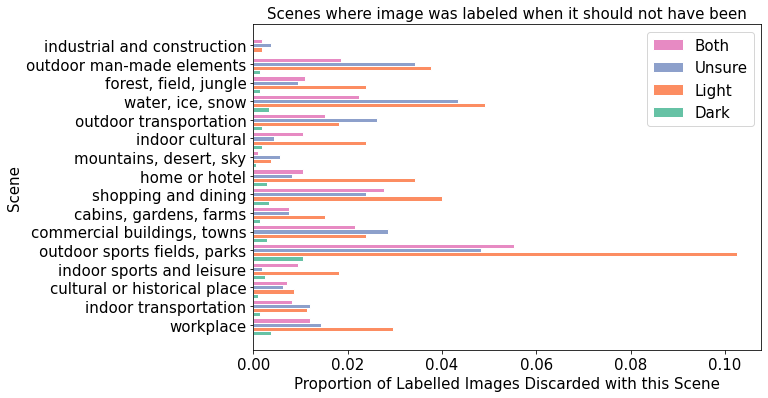

In [42]:
numbers_where_attribute_inferred()
scenes_where_no_face()

Distribution by attribute of sizes and distances, both after removing images where attribute was unlikely to be able to be labeled, all sizes before any images were removed, and the sizes of people where no face was detected.

In [43]:
if first_pass:
    compare_sizedist('first_pass')
all_things = [comparisons_widget]
ui = HBox(all_things)
out = widgets.interactive_output(compare_sizedist, {'metric': comparisons_widget})
display(ui, out)

Output()

# (M2) Metric: Object occurrences and cooccurrences
<a id="metric2"></a>

## Setup
<a id="metric2_setup"></a>

In [28]:
categories = dataset.categories
names = dataset.labels_to_names
counts = pickle.load(open("results/{}/2.pkl".format(folder_name), "rb"))
topn = 10
counts_mat = [np.zeros((len(categories), len(categories))) for i in range(num_attrs)]
for key in counts[0].keys():
    a, b = key.split('-')
    a, b = int(a), int(b)
    for count in range(num_attrs):
        counts_mat[count][b][a] = counts[count][key]
        counts_mat[count][a][b] = counts[count][key]
instance_counts = [np.diagonal(counts_mat[i]) for i in range(num_attrs)]
normalized = [np.divide(counts_mat[i], instance_counts[i]) for i in range(num_attrs)]
            
def make_dist(counts, total):
    samples = np.zeros(total)
    samples[:int(counts)] = 1
    return samples
# Looking at if the number of times an object appears with different attributes is statistically significant for some specific attr (analyze_attr)
p_values = []
for i in range(len(instance_counts[0])):
    for a in range(num_attrs):
        for b in range(a+1, num_attrs):
            p_values.append(stats.ttest_ind(make_dist(instance_counts[b][i], dataset.num_skin_tone_images[b]), make_dist(instance_counts[a][i], dataset.num_skin_tone_images[a]))[1])
            
norm_instance_counts = [instance_counts[i]/ dataset.num_skin_tone_images[i] for i in range(num_attrs)]
#print(norm_instance_counts)
xaxis = [names[i] for i in categories]
barWidth = .4

# Graphs the counts of each supercategory by gender
def supercategory_by_attribute():
    if dataset.group_mapping is not None:
        fontsize = 15
        supercategory_counts = [np.zeros(len(datasets.GROUPINGS_TO_NAMES)) for i in range(num_attrs)]
        for i in range(len(categories)):
            supercat = dataset.group_mapping(categories[i])
            for a in range(num_attrs):
                supercategory_counts[a][supercat] += norm_instance_counts[a][i]
        for a in range(num_attrs):
            supercategory_counts[a] = supercategory_counts[a][1:]
        supercategory_counts = [np.array(supercategory_counts[i]) for i in range(num_attrs)]
        
        fig = plt.figure(figsize=(10, 6))
        r1 = np.arange(len(datasets.GROUPINGS_TO_NAMES)-1)
        r1 = [r1[i]+i*4*barWidth for i in range(len(r1))]
        r = [r1]
        for i in range(1, num_attrs+1):
            r.append([x + barWidth for x in r[len(r)-1]])

        category_attr_ratios = [0 for i in range(len(supercategory_counts[0]))]
        max_categories = [0 for i in range(len(supercategory_counts[0]))]
        for category in range(len(supercategory_counts[0])):
            max_category = 0
            min_category = 1
            max_attr = -1
            for attr in range(num_attrs):
                if supercategory_counts[attr][category] > max_category:
                    max_category = supercategory_counts[attr][category]
                    max_attr = attr
                if supercategory_counts[attr][category] < min_category:
                    min_category = supercategory_counts[attr][category]
            category_attr_ratios[category] = max_category / min_category
            max_categories[category] = max_attr
            
        order = np.argsort(category_attr_ratios)
        r = np.array(r)
        for i in range(num_attrs-1, -1, -1):
            plt.barh(r[i], supercategory_counts[i][order], height=barWidth, color=COLORS[i], edgecolor='white', label=attr_names[i])
        
        ticks = [r[0]+(num_attrs/2)*barWidth for i in range(len(r1))][0]
        plt.yticks(ticks, np.array([datasets.GROUPINGS_TO_NAMES[i+1] for i in range(len(r1))])[order], fontsize=fontsize)
        plt.xticks(fontsize=fontsize)
        plt.legend(loc='best', fontsize=fontsize)
        plt.ylabel('Object Category', fontsize=fontsize, labelpad=20)
        plt.xlabel('Fraction of Labelled Images that contain this Category', fontsize=fontsize, labelpad=20, x=.3)
        plt.tight_layout()
        plt.gcf().subplots_adjust(bottom=0.18)
        plt.gcf().subplots_adjust(left=0.28)
        if first_pass:
            to_write[3] = ['(M2) Distribution of object categories each attribute appears with, sorted by ratio between the analyzed attribute and everything else.']
            plt.savefig("results/{0}/{1}/1.png".format(folder_name, save_loc))
        plt.show()

# Graphs the ratio of instance counts if they are statistically significant
indices_to_keep = [i for i in range(len(instance_counts[0])) if categories[i] not in dataset.people_labels]
instance_sig = [norm_instance_counts[i][indices_to_keep] for i in range(num_attrs)]
xaxis_sig = np.array(xaxis)[indices_to_keep]
pvalues_sig = np.array(p_values)[indices_to_keep]

count_attr_ratio = [0 for i in range(len(instance_sig[0]))]
max_counts = [0 for i in range(len(instance_sig[0]))]
for i in range(len(instance_sig[0])):
    max_count = 0
    min_count = 0
    max_attr = -1
    sum_cat = 0
    for attr in range(num_attrs):
        sum_cat += instance_sig[attr][i]
        if instance_sig[attr][i] > max_count:
            max_count = instance_sig[attr][i]
            max_attr = attr
    if sum_cat >0:
        count_attr_ratio[i] = float(max_count) / float(sum_cat)
    else:
        count_attr_ratio[i] = 0
    max_counts[i] = max_attr
all_ratios = np.array(count_attr_ratio)
max_counts = np.array(max_counts)

def show_instance_ratios(sort_by, topn):
    infinities = np.concatenate([np.where(all_ratios == -np.inf)[0], np.where(all_ratios == np.inf)[0]], axis=None)
    infinite_categories = max_counts[infinities]
    
    all_ratios[all_ratios == -np.inf] = 0
    all_ratios[all_ratios == np.inf] = 0
    
    to_save = False
    if topn is None:
        topn = 5
        to_save = True
    
    if sort_by == 'pvalue':
        top_indices = np.argsort(pvalues_sig)[:topn][::-1]
        if to_save:
            for i in reversed(range(topn)):
                if pvalues_sig[top_indices[i]] >= .05:
                    top_indices.pop()
            topn = len(top_indices)
            if len(top_indices) == 0:
                return
                to_save = False
    elif sort_by == 'ratio':
        top_indices = np.argsort(np.absolute(all_ratios))[-topn:]
    instance_sig_topn = [instance_sig[i][top_indices] for i in range(num_attrs)]
    xaxis_sig_topn = xaxis_sig[top_indices]
    all_ratios_topn = all_ratios[top_indices]

    fig = plt.figure(figsize=(10, max(2, topn // 3)))
    fontsize = 10
    
    pltbar = plt.barh(np.arange(topn), np.absolute(all_ratios_topn))
    for bar in range(len(pltbar)):
        pltbar[bar].set_color(COLORS[max_counts[top_indices][bar]])
        
    plt.yticks(np.arange(topn), xaxis_sig_topn[:topn], rotation='horizontal', fontsize=fontsize)
    ax = plt.gca()
    ax.tick_params(axis="x", bottom=True, top=True, labelbottom=True, labeltop=True)
    ax.tick_params(axis="y", left=False, right=True, labelleft=False, labelright=True)
    plt.ylabel('Categories', fontsize=fontsize)
    plt.xlabel('Counts Ratio', fontsize=fontsize)
    patches = [mpatches.Patch(color=COLORS[i], label=attr_names[i]) for i in range(num_attrs)]
    handles = patches
    fontP = FontProperties()
    fontP.set_size(12)
    lgd = plt.legend(handles=handles, prop=fontP, loc='best')
    plt.tight_layout()
    if to_save:
        to_write[4] = ['(M2) Objects that are most statistically significantly represented with one attribute over the other.']
        plt.savefig("results/{0}/{1}/2.png".format(folder_name, save_loc))
        plt.close()
        return
    else:
        plt.show()

    if len(infinities) > 0:
        print("Categories where one attribute had 0 occurrences with that object:\n")
        
    # Categories where all attributes had 0 occurrences with that object
    for index in infinities:
        print("{0} had 0 occurrences with all values of the attribute".format(xaxis_sig_topn[index]))

    print("The most common attribute associated each category in the graph is:\n")
    for index in reversed(range(topn)):
        attr = int(max_counts[top_indices][index])
        print("{0}: {1}={2}, proportion of total instances: {3}\n".format(xaxis_sig_topn[index], attr_names[attr], math.ceil(instance_sig_topn[attr][index]*dataset.num_skin_tone_images[attr]), round(np.absolute(all_ratios_topn[index]), 4)))
        
p_values = np.zeros_like(counts_mat[0])
attributes = np.array([[[-1,-1] for a in range(len(counts_mat[0][0]))] for b in range(len(counts_mat[0]))])
mi = [np.zeros_like(counts_mat[0]) for a in range(num_attrs)]
mi_wilson = [np.zeros_like(counts_mat[0]) for a in range(num_attrs)]

for i in range(len(categories)):
    for j in range(len(categories)):
        if categories[i] in dataset.people_labels or categories[j] in dataset.people_labels:
            p_values[i][j] = -1
        else:
            min_p = 100
            attr1 = -1
            attr2 = -1
            for a in range(num_attrs):
                for b in range(a+1, num_attrs):
                    len_a = instance_counts[a][j] + instance_counts[a][i] - counts_mat[a][i][j]
                    an = np.zeros(int(len_a))
                    an[:int(counts_mat[a][i][j])] = 1
                    mi[a][i][j] = np.mean(an)
                    mi_wilson[a][i][j] = wilson(np.mean(an), len_a)[0]
                    
                    len_b = instance_counts[b][j] + instance_counts[b][i] - counts_mat[b][i][j]
                    bn = np.zeros(int(len_b))
                    bn[:int(counts_mat[b][i][j])] = 1
                    mi[b][i][j] = np.mean(bn)
                    mi_wilson[b][i][j] = wilson(np.mean(bn), len_b)[0]
                    if mi[a][i][j] > 0 and mi[b][i][j] > 0:
                        p = stats.ttest_ind(an, bn)[1]
                    else:
                        p = 100
                    if p < min_p:
                        min_p = p
                        attr1 = a
                        attr2 = b
            p_values[i][j] = p
            attributes[i][j][0] = attr1
            attributes[i][j][1] = attr2

flat_p = p_values.flatten()
flat_p[flat_p!=flat_p] = float("inf")
flat_p[flat_p == -1] = float("inf")

flat_attributes = attributes.flatten()
attributes_dict = {}
for i in range(len(flat_p)):
    #Per 2 attributes in a ttest
    attributes_dict[flat_p[i]] = [flat_attributes[2*i], flat_attributes[2*i+1]]
    
normalized_indices = np.argsort(flat_p)

def cooccurrence_counts_mi(topn):
    print("Statistically significant mutual information:\n")
    i, j = 0, 0
    while j < topn:
        index = normalized_indices[i]
        a, b = index % len(categories), index // len(categories)
        if a < b:
            attr1 = attributes_dict[flat_p[index]][0]
            attr2 = attributes_dict[flat_p[index]][1]
            print("{0} - {1}: {2}".format(names[categories[a]], names[categories[b]], '{:0.3e}'.format(flat_p[index])))
            print("{0}: {1}, {2}: {3}".format(attr_names[attr1], round(mi[attr1].flatten()[index], 4), attr_names[attr2], round(mi[attr2].flatten()[index], 4)))
            print()
            j += 1
        i += 1

## Analysis
<a id="metric2_analyses"></a>

Distribution of object categories by gender

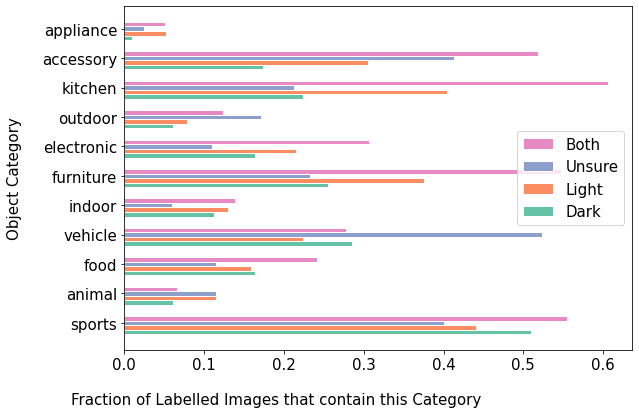

In [29]:
if dataset.group_mapping is not None:
    supercategory_by_attribute()

Ratio between how often an object is represented with each gender (normalized), sorted by p-value or ratio.

In [30]:
instanceratio_slider = widgets.IntSlider(min=5, max=50, step=1, value=10)
instanceratio_sortby = widgets.Dropdown(options=['pvalue', 'ratio'], value='pvalue')

if first_pass:
    show_instance_ratios('pvalue', None)

all_things = [instanceratio_sortby, instanceratio_slider]
ui = HBox(all_things)
out = widgets.interactive_output(show_instance_ratios, {'sort_by': instanceratio_sortby, 'topn': instanceratio_slider})
display(ui, out)

Output()

Most statistically significant object cooccurrences, measured by mutual information, between the genders. The p-value is shown for the difference of the distributions, and the numbers for "F" and "M" indicate the mutual information for each gender on the object pair.

In [31]:
interact(cooccurrence_counts_mi, topn=widgets.IntSlider(min=1, max=30, step=1, value=10));

interactive(children=(IntSlider(value=10, description='topn', max=30, min=1), Output()), _dom_classes=('widget…